Outline of the Notebook

Date: April 09, 2023
Filename: compare_current_vs_proposed.ipynb
Copyright @ Tanmoy Das


# Input

## Data Import

In [1]:
import data_preparation
import custom_func
import model, model2
import model_analysis

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
# Import data
spill_data = pd.read_excel('Inputs/data_oil_spill_resource_allocation_Arctic_2023.xlsx', sheet_name='spills', header=0).copy()
spill_data = spill_data.sample(n=1000, random_state=42, replace=True)  #+++
current_station_data = pd.read_excel('Inputs/data_oil_spill_resource_allocation_Arctic_2023.xlsx', sheet_name='current', header=0).copy()
current_input_param = pd.read_excel('Inputs/data_oil_spill_resource_allocation_Arctic_2023.xlsx', sheet_name='current input param', header=0).copy()


potential_station_data = pd.read_excel('Inputs/data_oil_spill_resource_allocation_Arctic_2023.xlsx', sheet_name='stations', header=0).copy()
potential_station_data = potential_station_data.iloc[[0, 4,7, 10, 11, 18]]
input_parameters = pd.read_excel('Inputs/data_oil_spill_resource_allocation_Arctic_2023.xlsx', sheet_name='Estimated parameters', header=0).copy()
sensitivity_dataR = gpd.read_file('Inputs/ArcGIS_data/Sensitivity_data/Sensitivity_data5.shp').copy()

In [3]:
len(spill_data)

1000

In [4]:
current_station_data

,Station #,Facility location,Coordinates,m,c,r
0,s6,Hay River,"(60.758054, -115.789890)",0,1400,4000
1,s9,Churchill,"(58.55084,-93.62352)",78,800,800
2,s200,Tuktoyaktuk,"(69.459, -132.974304)",50,100,257
3,s300,Iqaluit,"(63.742885, -68.464958)",24,200,400


## Data Processing

In [5]:
coordinates_st = custom_func.extract_station_coordinate(current_station_data)
current_st_coord = pd.DataFrame(coordinates_st[1]).T.reset_index().set_index('index')
current_st_coord.columns = ['St_Latitude', 'St_Longitude']
display(current_st_coord)

coordinates_st2 = custom_func.extract_station_coordinate(potential_station_data)
potential_st_coord = pd.DataFrame(coordinates_st2[1]).T.reset_index().set_index('index')
potential_st_coord.columns = ['St_Latitude', 'St_Longitude']
display(potential_st_coord)

coordinates_spill = custom_func.extract_spill_coordinate(spill_data)
spill_coord = pd.DataFrame(coordinates_spill[1]).T.reset_index().set_index('index')
spill_coord.columns = ['St_Latitude', 'St_Longitude']
display(spill_coord)

,St_Latitude,St_Longitude
index,,
s6,60.758053,-115.789886
s9,58.550838,-93.623520
s200,69.459000,-132.974304
s300,63.742886,-68.464958


,St_Latitude,St_Longitude
index,,
s1,70.000000,-134.000000
s5,60.529999,-114.379997
s8,60.060001,-95.889999
s11,62.669998,-92.708000
s12,73.400002,-88.160004
s19,63.150002,-69.680000


,St_Latitude,St_Longitude
index,,
o103,73.953308,-84.663979
o180,70.490967,-131.429703
o93,64.239845,-63.442661
o15,61.233242,-66.397713
o107,73.604279,-84.559357
...,...,...
o156,68.041595,-111.912453
o212,62.443607,-111.002525
o209,61.485672,-114.259880


## Locations before modeling
Fig of current facilities and potential proposed facilities

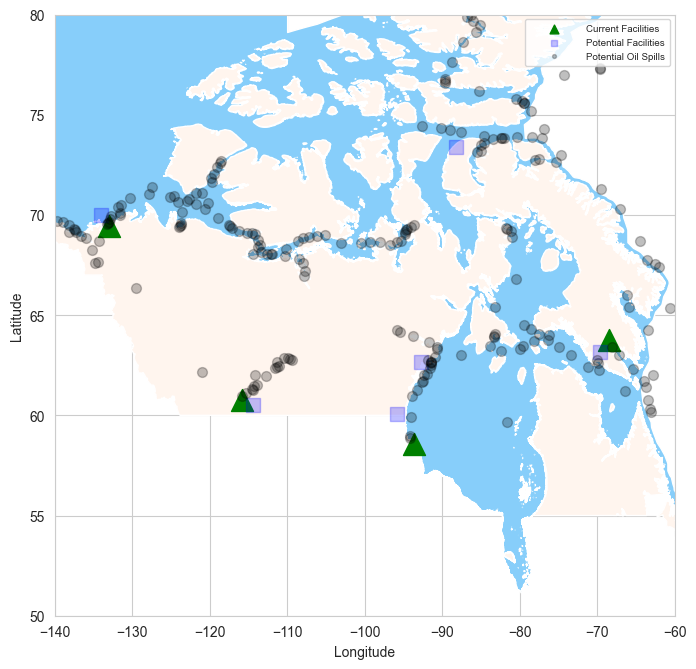

In [6]:
fig, ax = plt.subplots(figsize=(8,8))  #++
# Load geometric file for map
ArcticMap = gpd.read_file("Inputs/ArcGIS_data/ArcticShapefile2/ArcticShapefile2.shp")
ArcticMap = ArcticMap.to_crs(epsg=4326)  # 3857
ArcticLand = ArcticMap[ArcticMap['Region_EN'].isin(['Arctic'])]
ArcticWater = ArcticMap[ArcticMap['Region_EN'].isin(['Arctic-Water'])]
ArcticLand.plot(ax=ax, color="seashell")
ArcticWater.plot(ax=ax, color="lightskyblue")

st_current = plt.scatter(data=current_st_coord,
                 x='St_Longitude', y='St_Latitude', marker='^', alpha=1, s=250,
                 c='green')

st_potential = plt.scatter(data=potential_st_coord,
                 x='St_Longitude', y='St_Latitude', marker='s', alpha=.25, s=100,
                 c='blue')

spills = plt.scatter(data=spill_coord,
                 x='St_Longitude', y='St_Latitude', marker='o', alpha=.25, s=50,
                 c='black')

# legends of all shapes in this figure
plt.legend((st_current, st_potential, spills),
           ('Current Facilities', 'Potential Facilities', 'Potential Oil Spills'),
           ncol=1, handlelength=5, borderpad=.5, markerscale=.4,
           fontsize=7
           )
# plt.xticks([])
# plt.yticks([])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim([-140, -60])
plt.ylim([50, 80])
plt.show()

## Input parameters

In [7]:
current_station_data

,Station #,Facility location,Coordinates,m,c,r
0,s6,Hay River,"(60.758054, -115.789890)",0,1400,4000
1,s9,Churchill,"(58.55084,-93.62352)",78,800,800
2,s200,Tuktoyaktuk,"(69.459, -132.974304)",50,100,257
3,s300,Iqaluit,"(63.742885, -68.464958)",24,200,400


In [8]:
Stations, OilSpills, ResourcesD, Demand, Availability, Eff, Distance, TimeR, Cf_s, Cu_sor \
= data_preparation.generate_input_data(current_station_data, spill_data, current_input_param)

['s6', 's9', 's200', 's300']


In [9]:
NumberStMax = 6
DistanceMax = 15
TimeRMax = 220

In [10]:
#max(Distance.values())
SizeSpill = SizeSpill_R = list(spill_data['Spill size']).copy()
Sensitivity_R = custom_func.calculate_sensitivity(coordinates_spill[0], sensitivity_dataR)
# normalize
SizeSpill_n = dict(zip(OilSpills, custom_func.normalize(SizeSpill_R, min(SizeSpill_R), max(SizeSpill_R))))
Sensitivity_n = dict(zip(OilSpills, custom_func.normalize(Sensitivity_R, min(Sensitivity_R), max(Sensitivity_R))))

Distance_n = dict(zip(Distance.keys(), custom_func.normalize(Distance.values(), min(Distance.values()), max(Distance.values()))))
# (x_0-x_min)/(x_max-x_min)
Effectiveness_n = dict(zip(Eff.keys(), custom_func.normalize(Eff.values(), min(Eff.values()), max(Eff.values()))))

# Model

In [11]:
model, select, deploy, mvars, names, values, \
        spill_df, station_df, select_1s, deploy_1s, ResponseTimeM, coverage_percentage, assignment  \
    = model2.solve(Stations, OilSpills, ResourcesD, coordinates_st, coordinates_spill, SizeSpill, SizeSpill_n, \
          Demand, Sensitivity_R, Sensitivity_n, Eff, Effectiveness_n, Availability, NumberStMax, Distance, Distance_n, DistanceMax,  Cf_s, Cu_sor)

--------------MIP-moo--------
Set parameter Username
Academic license - for non-commercial use only - expires 2023-12-04
Set parameter PoolSolutions to value 1024
Set parameter PoolGap to value 0.8
Set parameter PoolSearchMode to value 2
Set parameter LogFile to value "Outputs/Logfiles/model_moo(Apr 12,1839).log"
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1555 rows, 900 columns and 2110 nonzeros
Model fingerprint: 0xfe1b03de
Variable types: 666 continuous, 234 integer (234 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [2e-04, 1e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+02]
         Reset PoolSearchMode to zero.

---------------------------------------------------------------------------
Multi-objectives: starting optimization

ValueError: Length of values (1000) does not match length of index (222)

# Output

## Fig 10(a) Map. of current vs proposed facilities with edges

In [ ]:
current_vs_proposed = 'current'

In [ ]:
model_analysis.draw_network_diagram(DistanceMax, NumberStMax, Sensitivity_R, spill_df, station_df, ResponseTimeM, coverage_percentage,
                         assignment, deploy_1s, select_1s, current_vs_proposed)

In [ ]:
assignment_line = pd.DataFrame(columns=list(assignment.columns.values))
for i, o in enumerate(assignment['Spill #'].unique()):
    minD = min(assignment.loc[assignment['Spill #'] == o]['Distance'])
    df = assignment.iloc[np.where(assignment['Distance'] == minD)[0]]
    assignment_line = pd.concat([assignment_line, df])

resource_allocation_c = assignment_line[['Station no.', 'Resource Type', 'Quantity deployed']]
resource_allocation_c = resource_allocation_c.sort_values(by=['Station no.'])
resource_allocation_c = resource_allocation_c.groupby(['Station no.', 'Resource Type'])['Quantity deployed'].mean().reset_index()
resource_allocation_c
resource_allocation_c['Facility'] = 'Current'

### Proposed location allocation

In [ ]:
#NumberStMax = 4

In [ ]:
# Input param
Stations, OilSpills, ResourcesD, Demand, Availability, Eff, Distance, TimeR, Cf_s, Cu_sor \
= data_preparation.generate_input_data(potential_station_data, spill_data, input_parameters)

SizeSpill = SizeSpill_R = list(spill_data['Spill size']).copy()
Sensitivity_R = custom_func.calculate_sensitivity(coordinates_spill[0], sensitivity_dataR)
# normalize
SizeSpill_n = dict(zip(OilSpills, custom_func.normalize(SizeSpill_R, min(SizeSpill_R), max(SizeSpill_R))))
Sensitivity_n = dict(zip(OilSpills, custom_func.normalize(Sensitivity_R, min(Sensitivity_R), max(Sensitivity_R))))
Distance_n = dict(zip(Distance.keys(), custom_func.normalize(Distance.values(), min(Distance.values()), max(Distance.values()))))
# (x_0-x_min)/(x_max-x_min)
Effectiveness_n = dict(zip(Eff.keys(), custom_func.normalize(Eff.values(), min(Eff.values()), max(Eff.values()))))

# Model
model, select, deploy, mvars, names, values, \
        spill_df, station_df, select_1s, deploy_1s, ResponseTimeM, coverage_percentage, assignment  \
    = model2.solve(Stations, OilSpills, ResourcesD, coordinates_st2, coordinates_spill, SizeSpill, SizeSpill_n, \
          Demand, Sensitivity_R, Sensitivity_n, Eff, Effectiveness_n, Availability, NumberStMax, Distance, Distance_n, DistanceMax,  Cf_s, Cu_sor)

current_vs_proposed = 'proposed'
# Draw the network
assignment_line = model_analysis.draw_network_diagram(DistanceMax, NumberStMax, Sensitivity_R, spill_df, station_df, ResponseTimeM, coverage_percentage,
                         assignment, deploy_1s, select_1s, current_vs_proposed)

## Fig 10(b) Barplot. Resource allocation:
stockpile of m,c,i in each proposed facilities

In [ ]:
assignment_line = pd.DataFrame(columns=list(assignment.columns.values))
for i, o in enumerate(assignment['Spill #'].unique()):
    minD = min(assignment.loc[assignment['Spill #'] == o]['Distance'])
    df = assignment.iloc[np.where(assignment['Distance'] == minD)[0]]
    assignment_line = pd.concat([assignment_line, df])

resource_allocation_p = assignment_line[['Station no.', 'Resource Type', 'Quantity deployed']]
resource_allocation_p = resource_allocation_p.sort_values(by=['Station no.'])
resource_allocation_p = resource_allocation_p.groupby(['Station no.', 'Resource Type'])['Quantity deployed'].mean().reset_index()
resource_allocation_p
resource_allocation_p['Facility'] = 'Proposed'

In [ ]:
resource_allocation = pd.concat([resource_allocation_c, resource_allocation_p])
resource_allocation

In [ ]:
plt.bar(data=resource_allocation,
        x="Station no.", height="Quantity deployed",
        alpha = 0.5, hatch = 'Resource Type'
        ) # color='Facility'

In [ ]:
fig = plt.figure()
ax = sns.barplot(data=resource_allocation,
                 x="Station no.", y="Quantity deployed", errorbar=None,
                 hue='Facility', palette=["g", "yellow"],
                 alpha=0.7)
#sns.set_style(style='white')
ax.grid(False)
plt.show() #, ls='Resource Type'
fig.savefig('Outputs/barplot_compare.png', transparent=True)

In [ ]:
fig10c = plt.subplots(figsize=(7,3.5))
ax = sns.barplot(data=resource_allocation,
                 x="Station no.", y="Quantity deployed", errorbar=None,
                 hue='Facility', palette=["g", "yellow"],
                 alpha=0.7)
sns.set_style(style='white')
ax.grid(False)
plt.savefig('Outputs/barplot_compareHatch.png', transparent=True)

In [ ]:
fig10c = plt.subplots(figsize=(7,3.5))
ax = sns.barplot(data=resource_allocation,
                 x="Station no.", y="Quantity deployed", errorbar=None,
                 hue='Facility', palette=["g", "yellow"],
                 alpha=0.7)
hatches = ['', '', '', '', '', 'o','o', 'o','','','', '', '', '', '', 'o','o', 'o']
# Loop over the bars
for i,thisbar in enumerate(ax.patches):
    # Set a different hatch for each bar
    thisbar.set_hatch(hatches[i])
sns.set_style(style='white')
ax.grid(False)
plt.savefig('Outputs/barplot_compareHatch.png', transparent=True)

In [ ]:
ax.patches

## Fig 10(c) Violin & Zitter plot.
Compare performance metric (coverage, response time & cost)

In [ ]:
data_compare = pd.read_excel('Outputs/current vs proposed.xlsx', skiprows=[0])

In [ ]:
data_compare.info()
coverage_df_stacked = data_compare[['Current','Proposed']].copy().stack().reset_index()
coverage_df_stacked.columns = ['Index','Facility','Coverage']
cost_df_stacked = data_compare[['Current.1','Proposed.1']].copy().stack().reset_index()
cost_df_stacked.columns = ['Index','Facility','Cost']

time_df_stacked = data_compare[['Current.2','Proposed.2']].copy().stack().reset_index()
time_df_stacked.columns = ['Index','Facility','Response Time']


In [ ]:
time_df_stacked

In [ ]:
coverage_df_stacked

In [ ]:
def draw_boxplot(data, y, ax):
    sns.violinplot(data= data,x='Facility', y=y, alpha = 0.5)
    sns.stripplot(data= data, x='Facility', y=y)
    plt.ylabel = y


In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
draw_boxplot(coverage_df_stacked, 'Coverage', ax1)
draw_boxplot(cost_df_stacked, 'Cost', ax2)
draw_boxplot(time_df_stacked, 'Response Time', ax3)

plt.show()
fig.savefig('Outputs/boxplot_{}.png', transparent=True)

In [ ]:
plt.rcParams["figure.figsize"] = [7.00, 3]
plt.rcParams['axes.edgecolor'] = 'lightgray'
fig, (ax1, ax2, ax3) = plt.subplots(1,3)

sns.boxplot(data= coverage_df_stacked, ax=ax1, x='Facility', y='Coverage',
            boxprops=dict(alpha=.3), palette=["g", "yellow"])
sns.stripplot(data= coverage_df_stacked, ax=ax1, x='Facility', y='Coverage',
              alpha=.3)


sns.boxplot(data= cost_df_stacked, ax=ax2, x='Facility', y='Cost',
            boxprops=dict(alpha=.3), palette=["g", "yellow"])
sns.stripplot(data= cost_df_stacked, ax=ax2, x='Facility', y='Cost',
              alpha=.3)
sns.boxplot(data= time_df_stacked, ax=ax3, x='Facility', y='Response Time',
            boxprops=dict(alpha=.3), palette=["g", "yellow"])
sns.stripplot(data= time_df_stacked, ax=ax3, x='Facility', y='Response Time',
              alpha=.3)
plt.tight_layout()

#plt.axis('off')
# plt.xlabel('')
plt.show()
fig.savefig('Outputs/boxplot.png', transparent=True)

# Pareto Front

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
data_pareto_front = pd.read_excel('Outputs/pareto front.xlsx', sheet_name='pareto front')
data_pareto_front